In [147]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"})
import numpy as np
from data.plastic import HARDENING, materials, Y0
from models.MLP_incr import load_model, MLP_incr
import os.path as osp
import os
import torch

def plot_response(eps, sig_true, sig_pred, t, plot_iter=[((0,1),'black')]):
    fig = plt.figure(figsize=(8, 4),dpi=150)
    gs = GridSpec(2, 2, height_ratios=[1, 1])
    # fig.suptitle(r'', fontsize=18)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    N = eps.shape[0]

    for interval, color in plot_iter:
        
        start = int(interval[0]*N)
        end   = int(interval[1]*N)

        ax1.plot(eps[start:end],sig_pred[start:end],c=color,lw=1.5)
        ax1.plot(eps[start:end],sig_true[start:end],c=color,lw=2,alpha=0.3)
        ax2.plot(t[start:end],eps[start:end],c=color,lw=1.5)
        ax3.plot(t[start:end],sig_pred[start:end],c=color,lw=1.5)
        ax3.plot(t[start:end],sig_true[start:end],c=color,lw=2,alpha=0.3)

    #for ax_i in [ax1,ax2,ax3]:
    #    ax_i.set_xticks([])  # Remove x-axis numbers
    #    ax_i.set_yticks([])
    ax1.set_xlabel(r'$\varepsilon$', fontsize=18)
    ax2.set_xlabel(r'$t$', fontsize=18)
    ax3.set_xlabel(r'$t$', fontsize=18)
    ax1.set_ylabel(r'$\sigma$', fontsize=18)
    ax2.set_ylabel(r'$\varepsilon$', fontsize=18)
    ax3.set_ylabel(r'$\sigma$', fontsize=18)

# Eval of set of models

In [ ]:
k,p,q = 7,8,3
train_session = f'MLP_incr_tuned_{k}-{p}-{q}'

base_path = osp.join('metrics','models',train_session)

/tmp/ipykernel_20845/1787931294.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(loc='upper right', fontsize=8, ncol=1)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/users/rdsup/Desktop/EP-neural-nets/metrics/models/MLP_incr_tune_7-8-3/convergence.png'

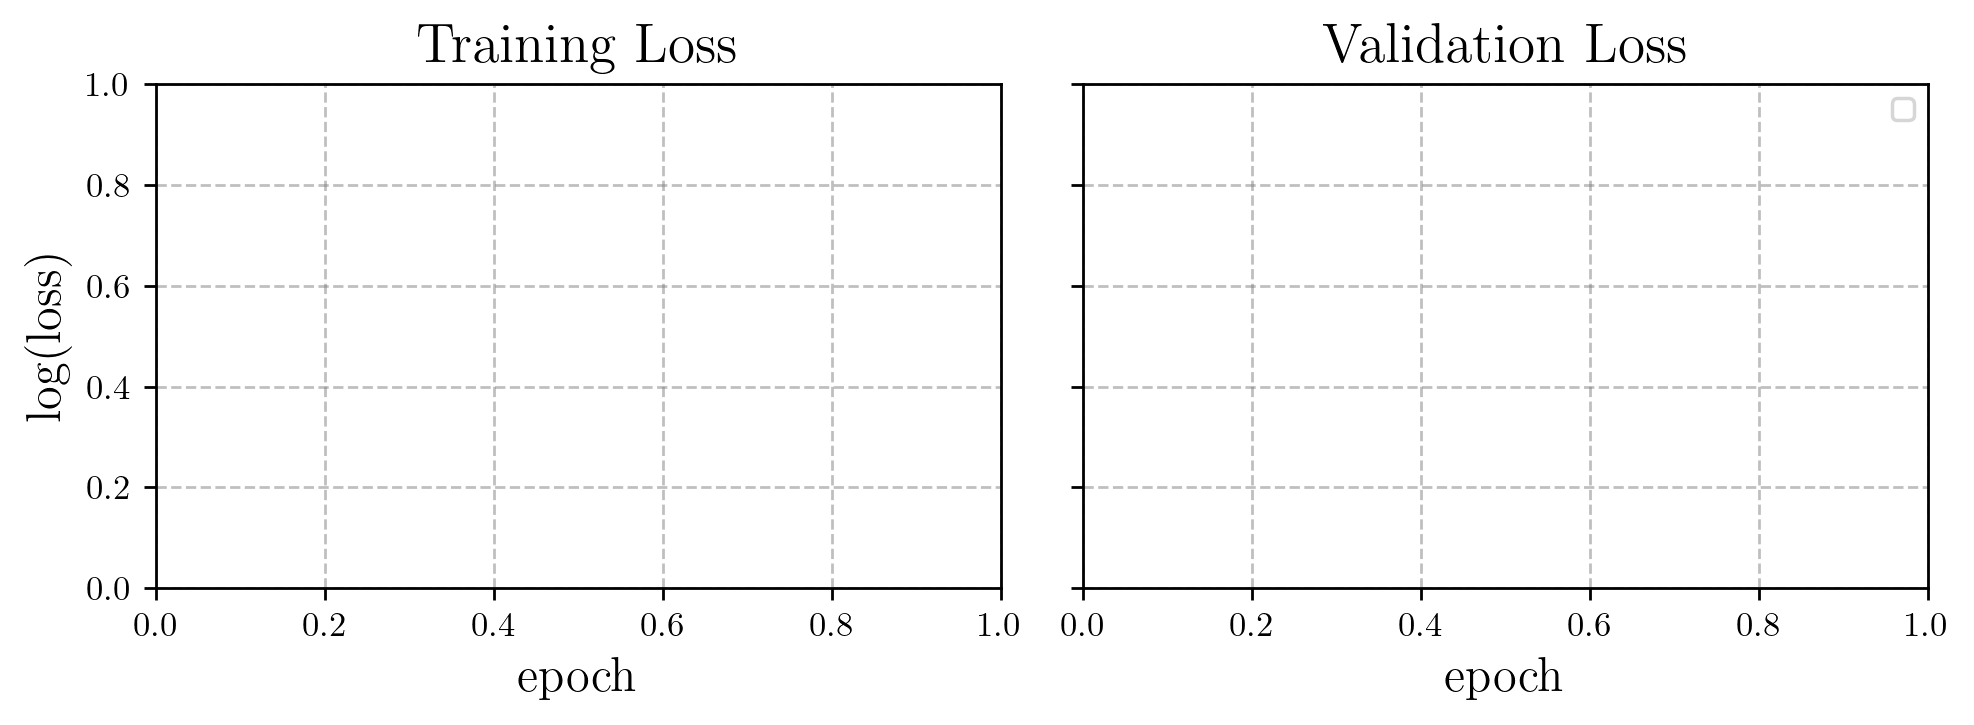

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3),dpi=250,sharey=True)
for name in materials:
    model_path = osp.join(base_path,name)
    if osp.exists(model_path):
        model = load_model(osp.join(model_path,'model.pth'))
        ax[0].semilogy(model.train_losses, label=name, color=materials[name]['color'], lw=1.5)
        ax[1].semilogy(model.val_losses, label=name, color=materials[name]['color'], lw=1.5)

ax[0].set_title('Training Loss',fontsize=16)
ax[1].set_title('Validation Loss',fontsize=16)
ax[0].set_ylabel('log(loss)',fontsize=14)
ax[0].set_xlabel('epoch',fontsize=14)
ax[1].set_xlabel('epoch',fontsize=14)
ax[0].grid(ls='--',color='gray',alpha=0.5)
ax[1].grid(ls='--',color='gray',alpha=0.5)
ax[1].legend(loc='upper right', fontsize=8, ncol=1)
plt.tight_layout()
plt.savefig(osp.join(base_path,'convergence.png'))
plt.show()

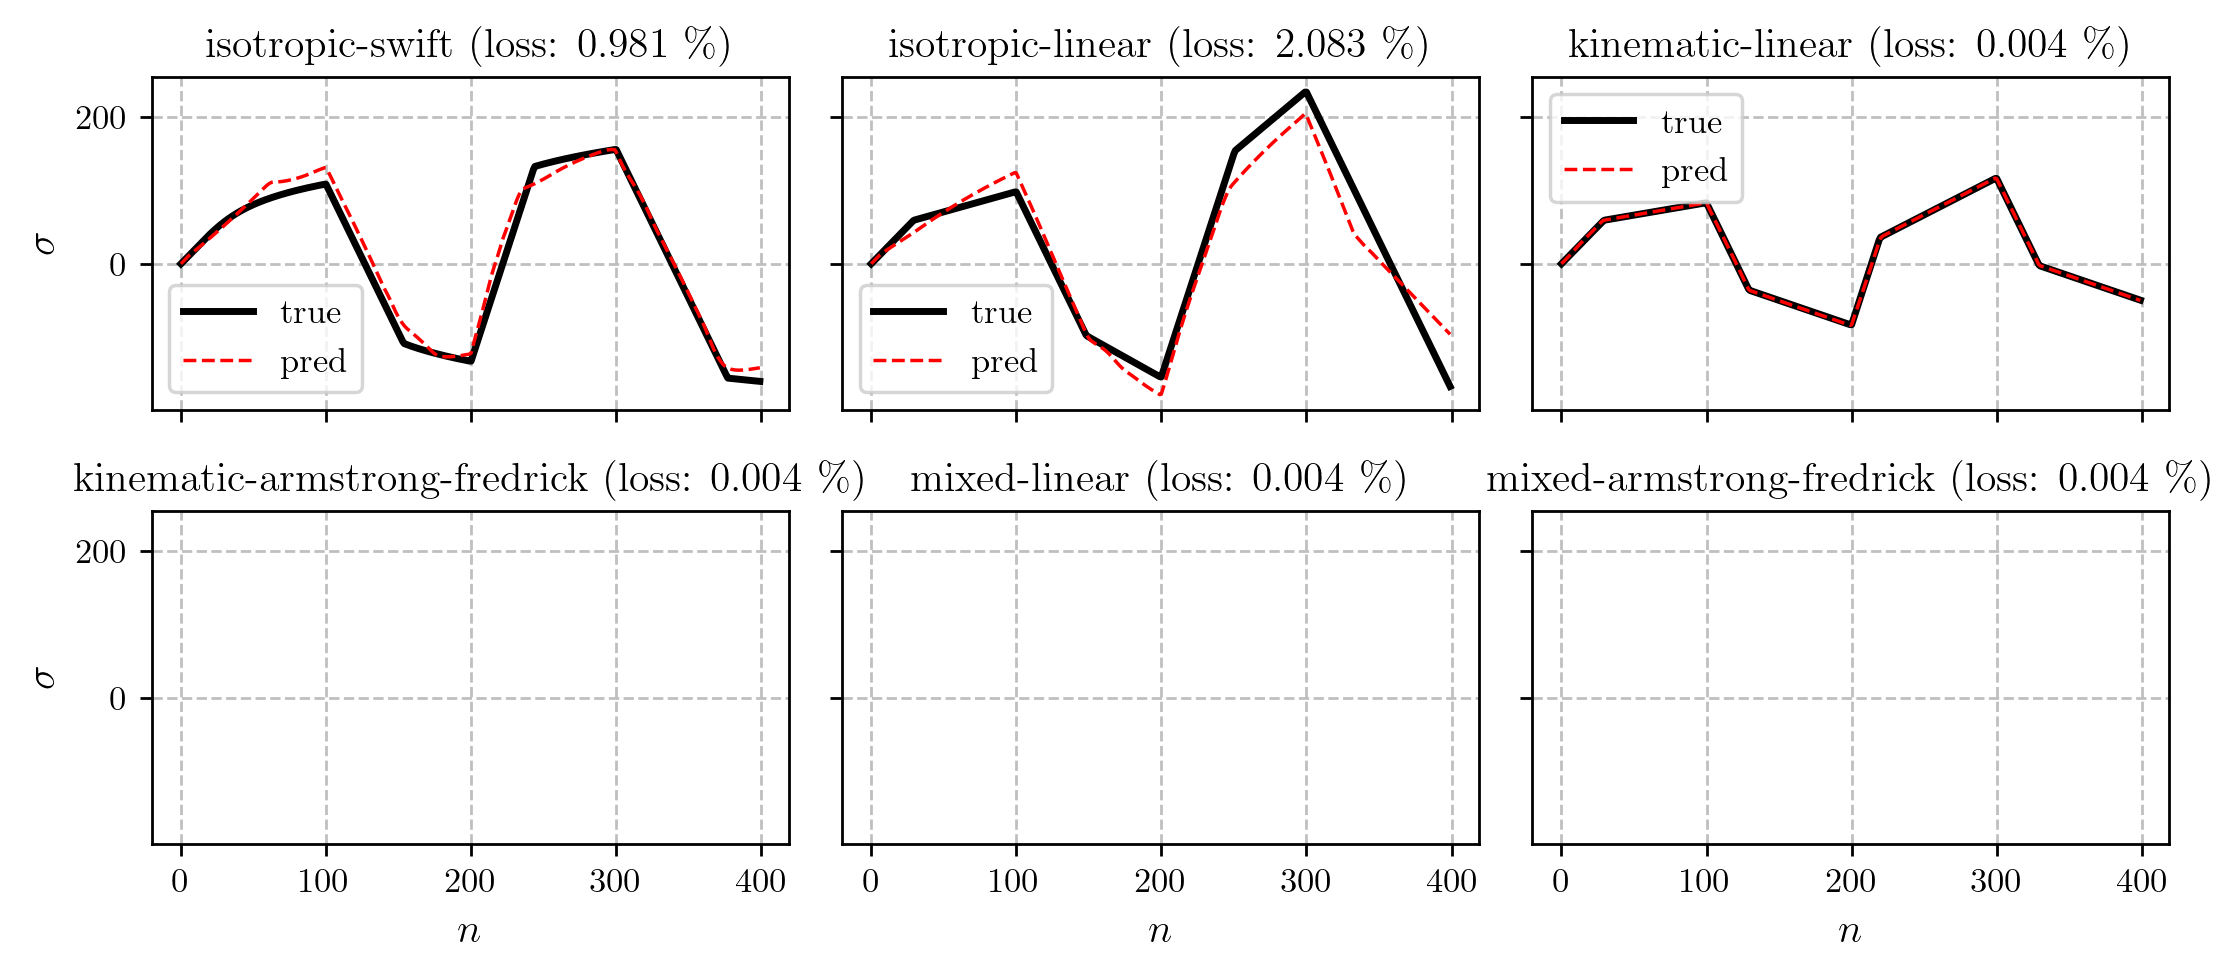

In [108]:
fig, ax = plt.subplots(2,3, figsize=(9, 4),dpi=250,sharex=True,sharey=True)
for i in range(ax.shape[1]): ax[-1,i].set_xlabel(r'$n$',fontsize=12)
for i in range(ax.shape[0]): ax[i,0].set_ylabel(r'$\sigma$',fontsize=12)

ax = ax.flatten()
for i,name in enumerate(materials):
    model_path = osp.join(base_path,name)
    if osp.exists(model_path):
        model = load_model(osp.join(model_path,'model.pth'))

        data_path = osp.join('data','data-sets',name)
        u = torch.tensor(np.load(osp.join(data_path,'u_benchmark.npy')),dtype=torch.float32).unsqueeze(-1).unsqueeze(0)
        y = torch.tensor(np.load(osp.join(data_path,'y_benchmark.npy')),dtype=torch.float32).unsqueeze(-1).unsqueeze(0)

        error = model.evaluate(y,u)
        y_pred = model.predict(y[:,:k,0],u[:,:,0])
        ax[i].plot(y[0,:,0]/1e6, label='true', color='black', lw=2)
        ax[i].plot(y_pred[0].detach().numpy()/1e6, label='pred', color='red', lw=1,ls='--')
        ax[i].legend()
    
    
    ax[i].grid(ls='--',color='gray',alpha=0.5)
    ax[i].set_title(f'{name} (loss: {error*100:.3f} \\%)')

plt.tight_layout()
plt.savefig(osp.join(base_path,'benchmark-eval.png'))
plt.show()

# Check the AUTOREGRESSIVITY and TIME-SCALE INVARIANCE (OPTIONAL)

In [140]:
k,p,q = 7,8,3
train_session = f'MLP_incr_rand_{k}-{p}-{q}'
name =  'kinematic-linear'

model_path = osp.join('metrics','models',train_session,name)

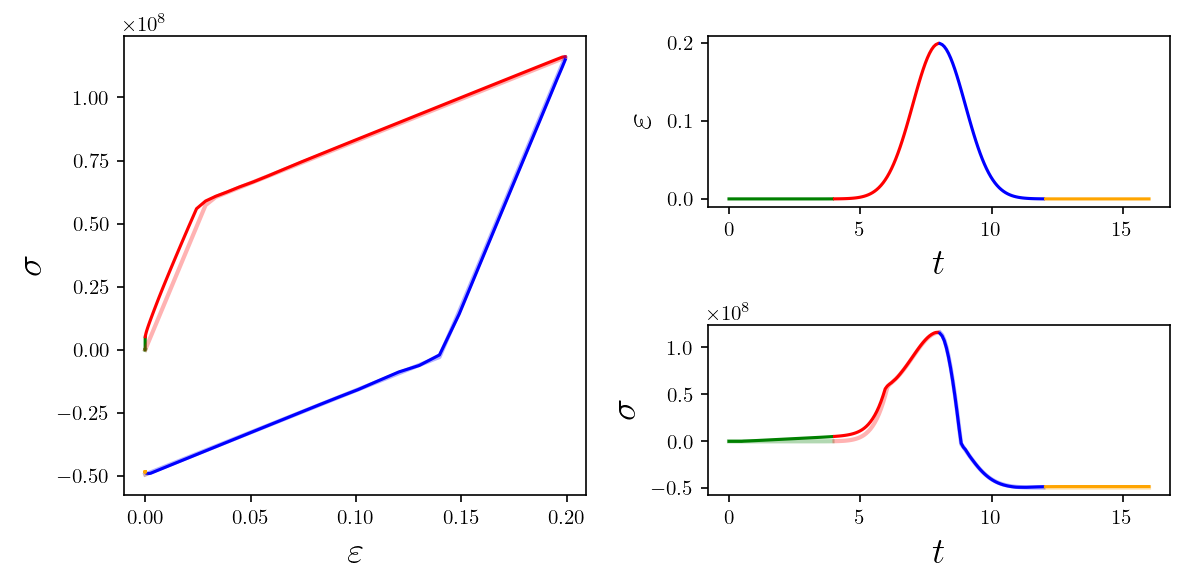

In [141]:
N = 200

# input signal
mu, sigma = 0, 1
t = np.linspace(mu - 8*sigma, mu + 8*sigma, N) 
eps = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((t - mu) / sigma)**2)/2
t -= mu - 8*sigma

# True response
mat = materials[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

# pred response
model = load_model(osp.join(model_path, f'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(
    eps, 
    sig_true, 
    sig_pred, 
    t,     
    plot_iter =  [
    ((0/4,1/4),'green'),
    ((1/4,2/4),'red'),
    ((2/4,3/4),'blue'),
    ((3/4,4/4),'orange'),
])
plt.tight_layout()
plt.savefig(osp.join(model_path,f'gauss_N={N}.png'))
plt.show()

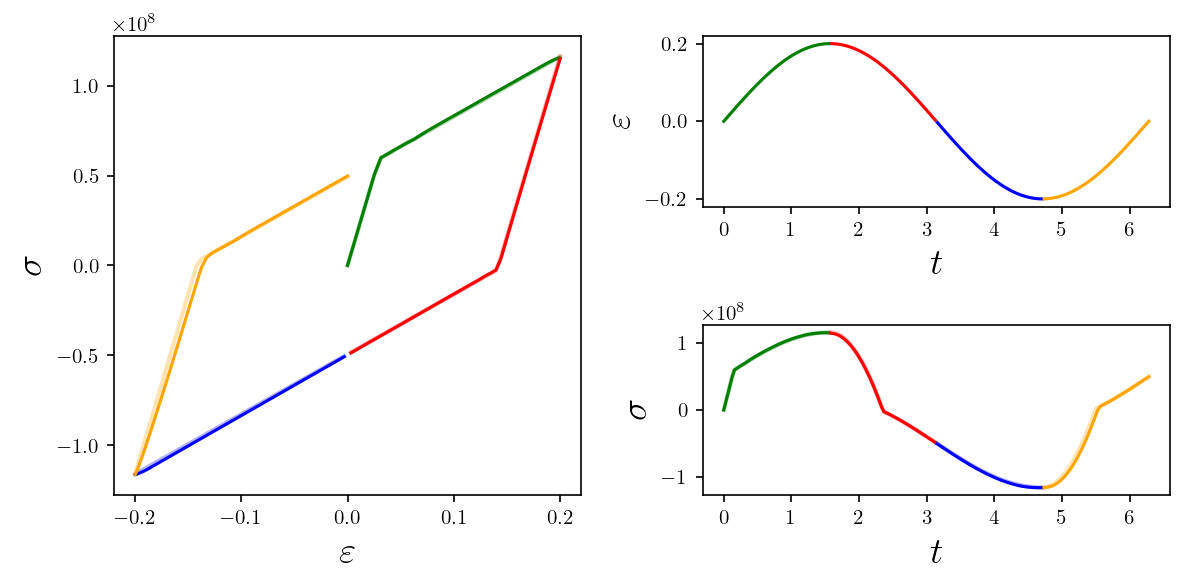

In [142]:
N = 200
 
t = np.linspace(0, 2*np.pi, N)
eps = np.sin(t) * 0.2

mat = materials[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

model = load_model(osp.join(model_path, 'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(
    eps, 
    sig_true, 
    sig_pred, 
    t,     
    plot_iter =  [
    ((0/4,1/4),'green'),
    ((1/4,2/4),'red'),
    ((2/4,3/4),'blue'),
    ((3/4,4/4),'orange'),
])
plt.tight_layout()
plt.savefig(osp.join(model_path,f'sin1_N={N}.png'))
plt.show()

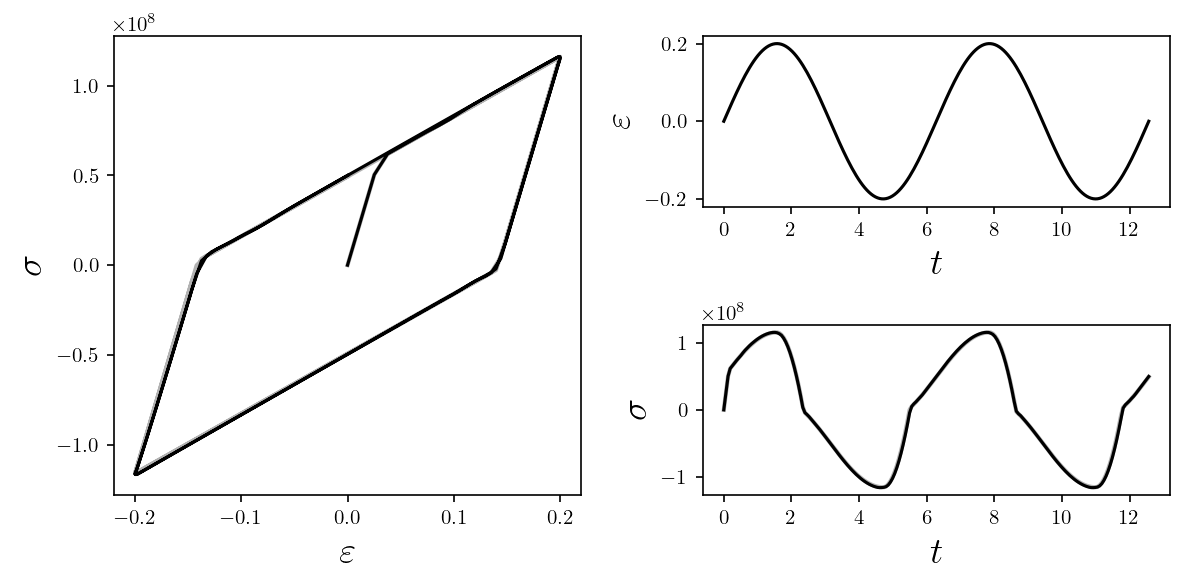

In [143]:
N = 200
 
t = np.linspace(0, 4*np.pi, N)
eps = np.sin(t) * 0.2

mat = materials[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

model = load_model(osp.join(model_path, 'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(eps, sig_true, sig_pred, t)
plt.tight_layout()
plt.savefig(osp.join(model_path,f'sin2_N={N}.png'))
plt.show()

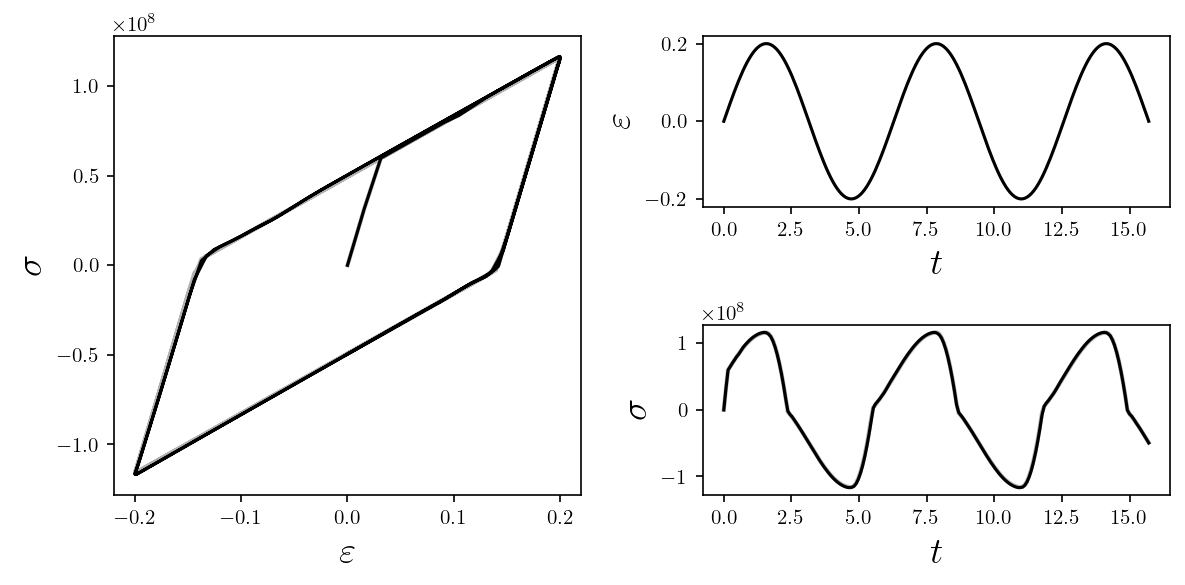

In [146]:
N = 200
 
t = np.linspace(0, 5*np.pi, N)
eps = np.sin(t) * 0.2

mat = materials[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

model = load_model(osp.join(model_path, 'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(eps, sig_true, sig_pred, t)
plt.tight_layout()
plt.savefig(osp.join(model_path,f'sin5_N={N}.png'))
plt.show()

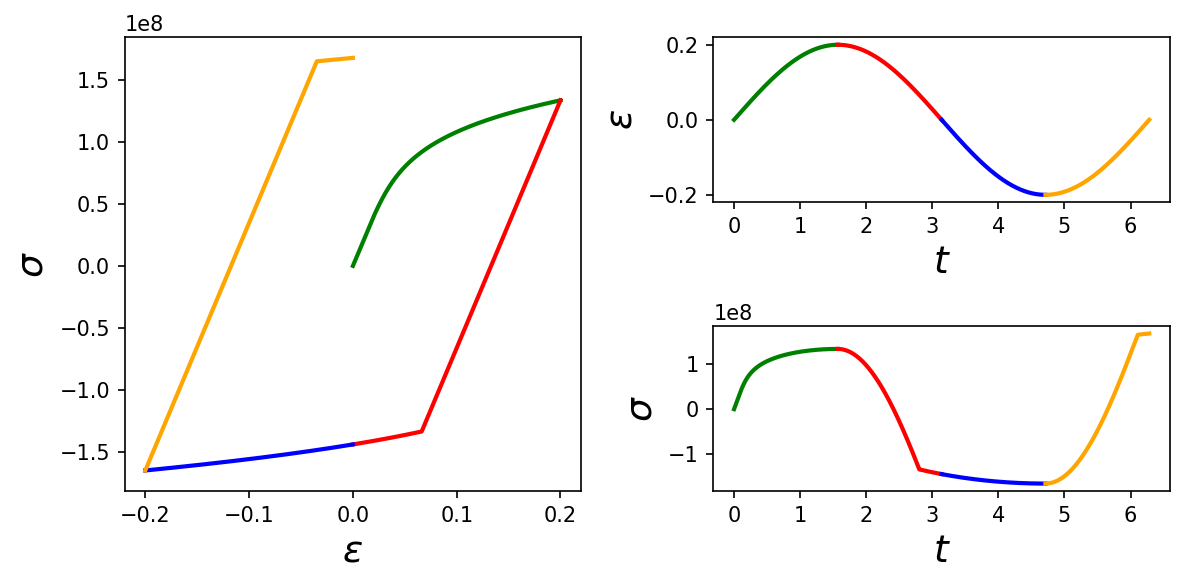

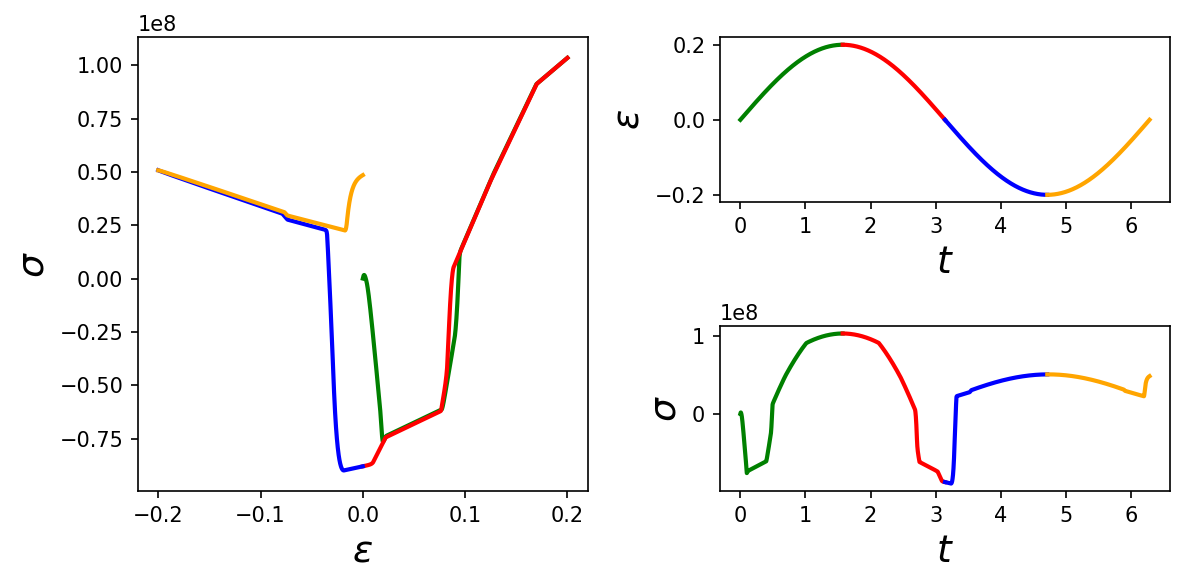

In [34]:
name =  'isotropic-swift'
epoch = 100

N = 10000

mu = 0  
sigma = 1
 
t = np.linspace(0, 2*np.pi, N)
eps = np.sin(t) * 0.2

mat = materials[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]
plot_response(eps, sig_true, t)

model = load_model(osp.join('metrics','models', name, f'{epoch}.pth'))

y0 = torch.tensor(sig_true[:3],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)

sig_pred = model.predict(y0, u).detach().numpy()[0]
plot_response(eps, sig_pred, t)

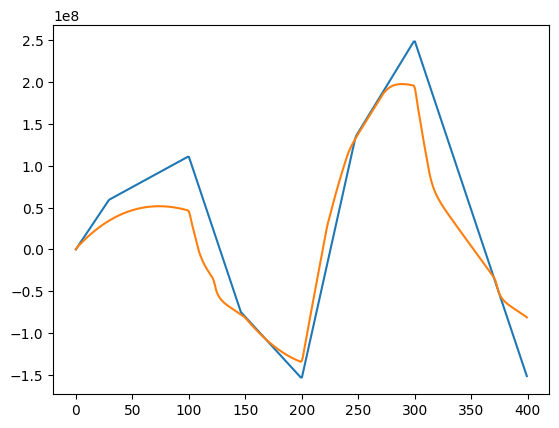

In [48]:
name =  'mixed-linear'

mat = materials[name]

eps = np.load(osp.join('data','data-sets', name, 'u_benchmark.npy'))
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]
plt.plot(sig_true)

model = load_model(osp.join('metrics','models', name, f'{epoch}.pth'))
y0 = torch.tensor(sig_true[:3],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]
plt.plot(sig_pred)